# Automatic Recognition of Lateral Flow Tests

I have tried uploading model weights as requested, but GradeScope rejects files over 100MB.

### README-Enviroment Configuration & Dependencies
Before running the code, create a new enviroment with all necessary libraries and dependencies. Below is a list of comands to run **in order** to build the enviroment in anaconda prompt. 

```bash
conda create -n detectron_env python=3.8
conda activate detectron_env
conda install pytorch torchvision torchaudio cudatoolkit=11.0 -c pytorch
pip install cython
git clone https://github.com/facebookresearch/detectron2
pip install -e .
pip install opencv-python matplotlib numpy pandas tqdm pillow scikit-image seaborn
conda config --add channels conda-forge
python -m ipykernel install --user --name=LTF_Project


_

Alternatively, to learn how to import Detectron2, this tutorial link which goes through similar steps in detail: [Detectron2 Installation Tutorial & Intro](https://www.youtube.com/watch?v=Pb3opEFP94U&ab_channel=TheCodingBug).

### Import Libraries

In [1]:
#Import Detectron's required libraries
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

#Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import os, json
import math
import seaborn as sns

#Skimage Packages
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.morphology import erosion
from skimage.color import rgb2gray
from skimage.io import imread
from skimage import io, color
from skimage.transform import rotate, resize
from skimage.util import crop

## Detectron2 Train 
Model weights already trained. **Only run to train again**

In [ ]:
#Load the prelabeled train and test datasets from local directory in folder ROI
register_coco_instances("my_dataset_train", {}, "ROI/train/instances_default.json", "ROI/train")
register_coco_instances("my_dataset_test", {}, "ROI/test/instances_default.json", "ROI/test")
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

In [7]:
#Configure Learninging Parameters for Training
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")) #Import pre-calibrated model
# For more info calibrated Mask RCNN model used, visit : https://arxiv.org/pdf/1703.06870.pdf
cfg.DATASETS.TRAIN = ("my_dataset_train")
cfg.DATASETS.TEST = ("my_dataset_test")
cfg.MODEL.DEVICE = "cpu" # Use "cuda" if you have a CUDA-enabled Nvidia GPU; otherwise, default to "cpu".
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # Learning Rate
cfg.SOLVER.MAX_ITER = 300   # 300 iterations is sufficient to plateu the model's training loss
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # The number of initial region proposals per image
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  #Only 1 class (ROI- LFT Casssete strip)


#Define output directory
cfg.OUTPUT_DIR = "model_weights/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
#Train the model
"""
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()
"""

### Model Training Results

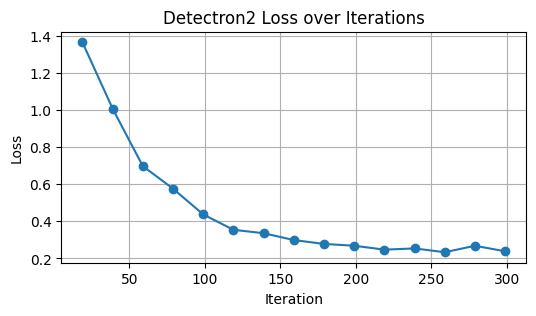

In [11]:
# Open the metrics file
with open('model_weights/metrics.json', 'r') as f:
    metrics_data = f.readlines()

# Store Results
iterations = []
losses = []

# Parse JSON data and extract iteration number and model loss
for line in metrics_data:
    data = json.loads(line)
    iteration = data['iteration']
    loss = data['total_loss']
    iterations.append(iteration)
    losses.append(loss)

# Plot figure
plt.figure(figsize=(6, 3))
plt.plot(iterations, losses, marker='o', linestyle='-')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.title('Detectron2 Training Loss over Iterations')
plt.grid(True)

# Save the plot as PDF
plt.savefig('Results/loss_over_iterations.pdf')

# Show the plot
plt.show()

# Calibrated Threshold Detector Model

### Load pre-trained model

In [2]:
#Configure Predicting Parameters
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml"))
cfg.MODEL.DEVICE = "cpu" 
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_C4_3x.yaml")
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
cfg.OUTPUT_DIR = "model_weights/" 
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

#Load Pre Trained Model Weights
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth") 

#Threshold parameter for sensitivity in detecting the cassette strip. Default set to 0.9 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9 

#Create the image processing predictor
predictor = DefaultPredictor(cfg)

### Data Preparation Functions

In [3]:
def detectron2_predictor(image_path):
    processed_images = []  # Store processed image cube
    result_data = {'Image ID': [], 'LFT Detection': []}  # Store Results Dataframe

    #Load jpg images
    image_paths = list(Path(image_path).glob('*.jpg'))

    for image_path in tqdm(image_paths):
        # Run ML predictor on image
        im = imread(str(image_path))
        outputs = predictor(im)
        masks = np.asarray(outputs["instances"].pred_masks.to("cpu"))

        #No LFT device detected in image
        if len(masks) == 0: 
            result_data['Image ID'].append(Path(image_path).name)
            result_data['LFT Detection'].append(False) #Update Dataframe with Rejected Image
            continue
        
        # LFT device detected in image
        result_data['Image ID'].append(Path(image_path).name)
        result_data['LFT Detection'].append(True) #Update Dataframe with Accepted Image

        # Get the bounding box of the mask
        segmentation = np.where(masks[0] == True)
        x_min = int(np.min(segmentation[1]))
        x_max = int(np.max(segmentation[1]))
        y_min = int(np.min(segmentation[0]))
        y_max = int(np.max(segmentation[0]))

        # Overlay cropped mask on the cropped image and remove background
        cropped = im[y_min:y_max, x_min:x_max, :]
        cropped_mask = np.expand_dims(masks[0, y_min:y_max, x_min:x_max] * 255, axis=2)
        cropped_mask = np.repeat(cropped_mask, 3, axis=2)
        cropped[:, :, :3][cropped_mask[:, :, 0] == 0] = 0
        
        # Convert from RGBA to grayscale
        image_gray = rgb2gray(cropped[:, :, :3])
        
        # Append the processed image to the list
        processed_images.append(image_gray)
        
    #Build Dataframe        
    result_dataframe = pd.DataFrame.from_records(result_data)
    
    
    return processed_images, result_dataframe

In [4]:
def image_rotator_and_crop(processed_images, target_size=(100, 50)):
    image_cube = []  # Store processed images

    # Function to crop images
    def crop_image_tighter(img, row_margin=-65, col_margin=-30): #Default calibrated to row_margin=-65, col_margin=-30
        rows = np.any(img, axis=1)
        cols = np.any(img, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]
        rmin = max(0, rmin - row_margin)
        rmax = min(img.shape[0], rmax + row_margin)
        cmin = max(0, cmin - col_margin)
        cmax = min(img.shape[1], cmax + col_margin)
        return img[rmin:rmax, cmin:cmax]

    #Loop over all processed images to rotate them
    for np_image in processed_images:        
        np_image = np.array(np_image)
        
        # Add a border of 0 pixels (prevents division by 0 issues when rotating image)
        np_image_with_border = np.pad(np_image, ((1, 1), (1, 1)), mode='constant', constant_values=0)
        
        # Apply thresholding to obtain binary image
        threshold_value = 0
        binary = np_image_with_border > threshold_value
        
        # Obtain Region props
        labeled_image = label(binary)
        regions = regionprops(labeled_image)
        props = regions[0]  # Assuming only one region
        y0, x0 = props.centroid
        orientation = props.orientation
        major_axis_length = props.major_axis_length
        minor_axis_length = props.axis_minor_length
        
        # Rotate the image around its centroid to set orientation to 0
        angle_to_rotate = math.degrees(-orientation)
        if angle_to_rotate > 45: #Prevent 180º flipping.
            angle_to_rotate = -angle_to_rotate  # Negate the angle
        rotated_image = rotate(np_image_with_border, angle_to_rotate, center=(x0, y0), resize=True)

        # Crop the rotated image based on a new bounding box
        binary = rotated_image > threshold_value
        labeled_image = label(binary)
        regions = regionprops(labeled_image)
        min_row, min_col, max_row, max_col = regions[0].bbox
        cropped_region = rotated_image[min_row:max_row, min_col:max_col]

        # Crop the rotated image tighter
        cropped_image_tighter = crop_image_tighter(cropped_region)

        # Resize the image to target size
        resized_image = resize(cropped_image_tighter, target_size)

        # Append the processed image to the image cube
        image_cube.append(resized_image)

    # Convert the list of images to a numpy array (image cube)
    image_cube = np.array(image_cube)

    return image_cube

### Filtering Functions

In [5]:
def row_filter(img_cube):
    # Get the dimensions of the image cube
    num_images, height, width = img_cube.shape
    
    # Calculate the average pixel values for each row in each image
    row_averages = np.mean(img_cube, axis=2)
    
    # Clip the row averages to ensure they are within the valid pixel value range [0, 255]
    row_averages = np.clip(row_averages, 0, 255)
    
    # Expand dimensions of row_averages to match the shape of img_cube
    row_averages_expanded = np.expand_dims(row_averages, axis=2)
    
    # Create filtered_cube by repeating row_averages along the width axis
    filtered_cube = np.repeat(row_averages_expanded, width, axis=2)
    
    return filtered_cube

In [6]:
def erode_images(processed_images):
    eroded_images = []
    kernel_size = 4
    selem = np.ones((kernel_size, kernel_size))  # Define erosion kernel

    for img in processed_images:
        eroded_img = erosion(img, footprint=selem)  # Erode the grayscale image
        eroded_images.append(eroded_img)

    return eroded_images

In [7]:
def apply_otsu_binary(image_cube):
    binary_cube = []
    for image in image_cube:
        threshold_value = threshold_otsu(image)
        binary_image = image > threshold_value
        binary_cube.append(binary_image)
    return np.array(binary_cube)

### Threshold Detector Function

In [8]:
def bin_threshold_detector(images,df):   
    results = []
    
    for img in images:
        # Invert the binary image so white objects are in foreground
        img = np.invert(img)
        
        # Label connected components in the binary image
        labeled_img = label(img)
        
        # Find regions in the labeled image
        props = regionprops(labeled_img)
        
        # Count objects with area greater than 200 pixels
        num_objects = sum(1 for prop in props if prop.area > 200)
        
        # Classify based on the number of objects
        if num_objects == 1:
            results.append("Negative")
        elif num_objects == 2:
            results.append("Positive")
        else:
            results.append("Inconclusive")

    results_df=pd.DataFrame({"Result": results})

    
    # Update dataframe 'Result' column based on 'LFT Detection' being True
    index_results_df = 0
    for index, row in df.iterrows():
        if row['LFT Detection']:
            df.at[index, 'Result'] = results_df.at[index_results_df, 'Result']
            index_results_df += 1
            
    return df


In [9]:
def multi_class_threshold_detector(images,df):   
    results = []
    
    for img in images:
        # Invert the binary image so that white objects are foreground
        img = np.invert(img)
        
        # Label connected components in the binary image
        labeled_img = label(img)

        #C-T Image segmentation
        # Split the image into top and lower halves
        height, width = labeled_img.shape
        top_half = labeled_img[:height//2, :]
        lower_half = labeled_img[height//2:, :]
        
        # Use regionprops to get properties of connected components in top half
        top_half_props = regionprops(top_half)
        
        # Use regionprops to get properties of connected components in lower half
        lower_half_props = regionprops(lower_half)
        
        # Count objects with area greater than 200 pixels for top half
        num_objects_top_half = sum(1 for prop in top_half_props if prop.area > 200)
        
        # Count objects with area greater than 200 pixels for lower half
        num_objects_lower_half = sum(1 for prop in lower_half_props if prop.area > 200)
        
        # Sum counts for top and lower halves
        total_objects = num_objects_top_half + num_objects_lower_half
        
        # Classify based on the number of objects
        if num_objects_top_half==1 and num_objects_lower_half==1:
            results.append("Positive")
        elif num_objects_top_half == 1 and num_objects_lower_half==0 :
            results.append("Negative")
        else:
            results.append("Inconclusive")

    results_df=pd.DataFrame({"Result": results})

   # Update dataframe 'Result' column based on 'LFT Detection' being True
    index_results_df = 0
    for index, row in df.iterrows():
        if row['LFT Detection']:
            df.at[index, 'Result'] = results_df.at[index_results_df, 'Result']
            index_results_df += 1
            
    return df


In [10]:
def plot_images(images):
    for img in images:
            plt.imshow(img, cmap="gray")
            plt.show()

# Main Function

The main function is by default set to run through images in image_directory and return a panda's dataframe with the test results.

For convinience, calibration and debugging. Each function output can be rested using **plot_images()**.

In [11]:
def main(img_directory, binary_model):  
    # 1. Data Preparation
    img_mask, result_dataframe = detectron2_predictor(img_directory)
    img_rot = image_rotator_and_crop(img_mask)
    
    # 2. Filters
    img_filt = row_filter(img_rot)
    img_erode = erode_images(img_filt)
    img_bin = apply_otsu_binary(img_erode)
    
    # 3. Threshold Detector
    if binary_model==True:
        #Binary Threshold Detector
        result_dataframe = bin_threshold_detector(img_bin, result_dataframe)
    else:    
        #Multi Class Threshold Detector
        result_dataframe = multi_class_threshold_detector(img_bin, result_dataframe)
        
    return result_dataframe   

## Results

In [24]:
option1_res=main("Option 1 data/", binary_model=True)
option1_res

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [02:19<00:00, 10.72s/it]


,Image ID,LFT Detection,Result
0,KFT_04.jpg,True,Negative
1,LDR_13.jpg,True,Negative
2,LDT_14.jpg,True,Positive
3,LFT_00.jpg,True,Positive
4,LFT_01.jpg,True,Negative
5,LFT_02.jpg,True,Negative
6,LFT_03.jpg,True,Negative
7,LFT_07.jpg,True,Positive
8,LFT_08.jpg,True,Negative
9,LFT_10.jpg,True,Negative


In [74]:
kaggle_data_res=main('Kaggle Dataset/', binary_model=True)
kaggle_data_res

100%|██████████████████████████████████████████████████████████████████████████████| 325/325 [1:00:20<00:00, 11.14s/it]


,Image ID,LFT Detection,Result
0,negative_1.jpg,True,Negative
1,negative_10.jpg,True,Negative
2,negative_11.jpg,True,Negative
3,negative_12.jpg,True,Negative
4,negative_13.jpg,True,Negative
...,...,...,...
320,positive_95.jpg,True,Positive
321,positive_96.jpg,True,Positive
322,positive_97.jpg,True,Positive
323,positive_98.jpg,True,Positive


In [14]:
control_res=main('Control Images/', binary_model=False)
control_res

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [05:46<00:00, 10.83s/it]


,Image ID,LFT Detection,Result
0,Invalid_1.jpg,True,Inconclusive
1,invalid_10.jpg,False,NaN
2,Invalid_2.jpg,True,Inconclusive
3,Invalid_3.jpg,True,Inconclusive
4,Invalid_4.jpg,True,Negative
5,Invalid_5.jpg,True,Inconclusive
6,Invalid_6.jpg,False,NaN
7,invalid_7.jpg,False,NaN
8,Invalid_8.jpg,True,Positive
9,Invalid_9.jpg,False,NaN


# Result Analysis

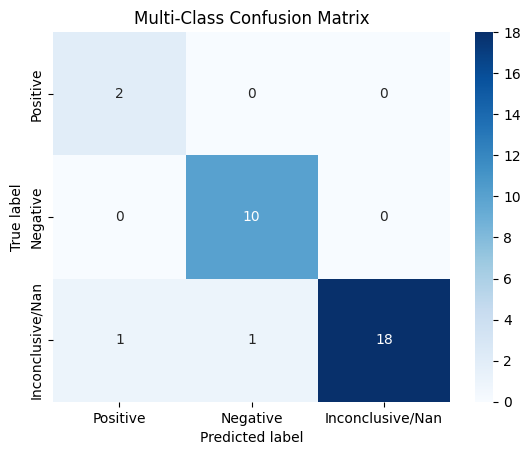

In [25]:
# Confusion Matrix data
#(Manually built matrices becuase model does not contain true labels)
control = np.array([[2, 0, 0],
                  [0, 10, 0],
                  [1, 1, 18]])

# Create confusion matrix
sns.heatmap(control, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Inconclusive/Nan'], yticklabels=['Positive', 'Negative', 'Inconclusive/Nan'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Multi-Class Confusion Matrix')

# Save confusion matrix as PDF
plt.savefig("Results/multi_class_confusion_matrix.pdf", format="pdf")

# Display the plot
plt.show()


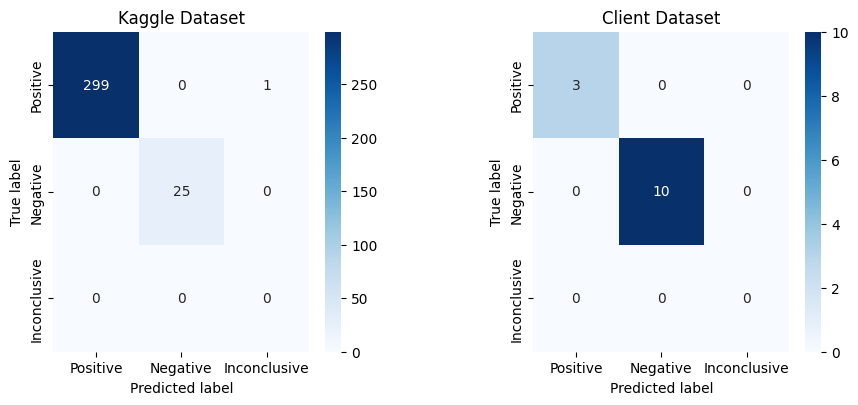

In [27]:
# Confusion Matrix data
#(Manually built matrices becuase model does not contain true labels)
kaggle = np.array([[299, 0, 1],
                  [0, 25, 0],
                  [0, 0, 0]])

client = np.array([[3, 0, 0],
                  [0, 10, 0],
                  [0, 0, 0]])

# Create subplots for each confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plot first confusion matrix
sns.heatmap(kaggle, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Inconclusive'], yticklabels=['Positive', 'Negative', 'Inconclusive'], ax=axes[0])
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')
axes[0].set_title('Kaggle Dataset')

# Plot second confusion matrix
sns.heatmap(client, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Inconclusive'], yticklabels=['Positive', 'Negative', 'Inconclusive'], ax=axes[1])
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('True label')
axes[1].set_title('Client Dataset')

# Adjust layout with increased spacing between subplots
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.5, hspace=0.2)

# Save confusion matrix as PDF
plt.savefig("Results/confusion_matrices.pdf", format="pdf")

# Display the plot
plt.show()


In [28]:
def calculate_precision(confusion_matrix):
    TP = confusion_matrix.diagonal().sum() 
    FP = confusion_matrix.sum() - TP
    
    # Precision calculation
    precision = TP / (TP + FP)
    
    return precision

# Example usage:
precision_control = calculate_precision(control)
precision_kaggle = calculate_precision(kaggle)
precision_client = calculate_precision(client)

print("Precision for Control Dataset:", precision_control)
print("Precision for Kaggle Dataset:", precision_kaggle)
print("Precision for Client Dataset:", precision_client)


Precision for Control Dataset: 0.9375
Precision for Kaggle Dataset: 0.9969230769230769
Precision for Client Dataset: 1.0


### Anomalies

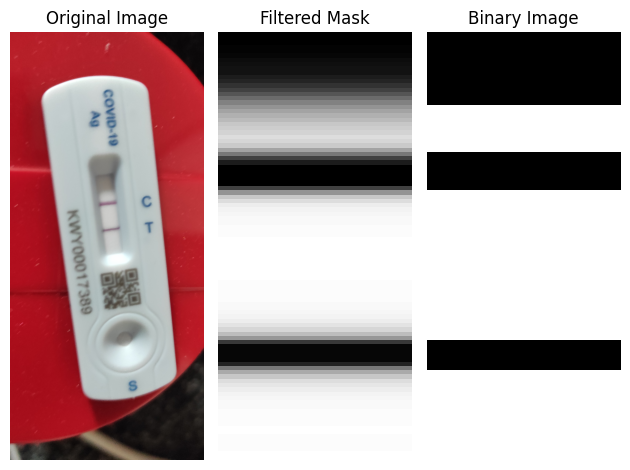

In [108]:
# Read the image from file
img_path = "Kaggle Dataset\Positive\\1649330010976.jpg"
img = imread(img_path)


# Plotting the first image
plt.subplot(1, 3, 1)
plt.imshow(img_rotated, cmap='gray', aspect='auto')  # Displaying in grayscale with aspect ratio auto
plt.title('Original Image')
plt.axis('off')  # Turn off axis

# Plotting the second image
plt.subplot(1, 3, 2)
plt.imshow(img_erode[149], cmap='gray', aspect='auto')
plt.title('Filtered Mask')
plt.axis('off')  # Turn off axis

# Plotting the third image
plt.subplot(1, 3, 3)
plt.imshow(img_bin[149], cmap='gray', aspect='auto')
plt.title('Binary Image')
plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.12s/it]


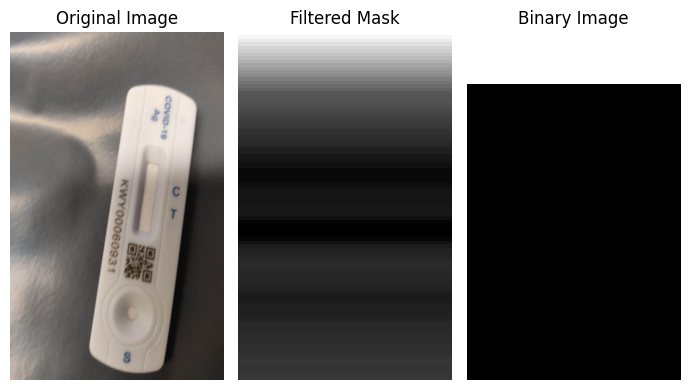

In [48]:
img_mask, result_dataframe = detectron2_predictor('Control/')
img_rot = image_rotator_and_crop(img_mask)

#Filters
img_filt = row_filter(img_rot)
img_erode = erode_images(img_filt)
img_bin = apply_otsu_binary(img_erode)

img_orig = imread('Control Images/Invalid_8.jpg')

# Plotting the first image
plt.subplot(1, 3, 1)
plt.imshow(img_orig, cmap='gray', aspect='auto')  # Displaying in grayscale with aspect ratio auto
plt.title('Original Image')
plt.axis('off')  # Turn off axis

# Plotting the second image
plt.subplot(1, 3, 2)
plt.imshow(img_erode[0], cmap='gray', aspect='auto')
plt.title('Filtered Mask')
plt.axis('off')  # Turn off axis

# Plotting the third image
plt.subplot(1, 3, 3)
plt.imshow(img_bin[0], cmap='gray', aspect='auto')
plt.title('Binary Image')
plt.axis('off')  # Turn off axis
plt.gcf().set_size_inches(7, 4)  # Adjust these values as needed
plt.tight_layout()
plt.show()


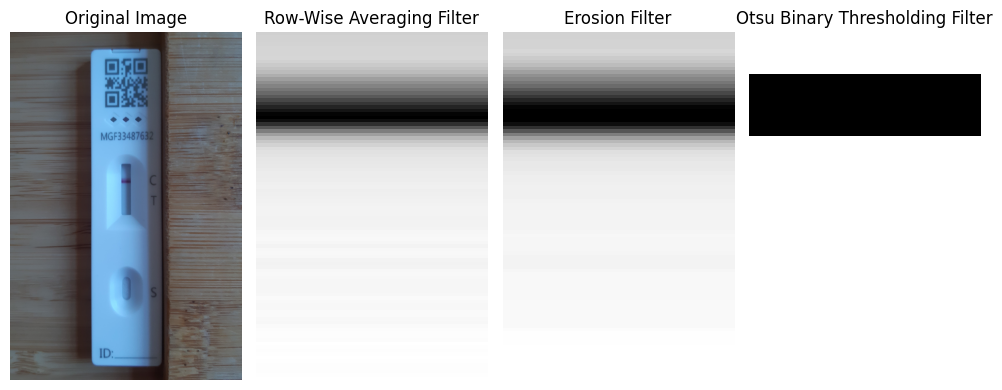

In [23]:
#img_mask, result_dataframe = detectron2_predictor('Control/')
img_rot = image_rotator_and_crop(img_mask)

# Filters
img_filt = row_filter(img_rot)
img_erode = erode_images(img_filt)
img_bin = apply_otsu_binary(img_erode)

img_orig = imread('Control/LGT_05.jpg')


# Plotting the first image
plt.subplot(1, 4, 1)
plt.imshow(img_orig, cmap='gray', aspect='auto')  # Displaying in grayscale with aspect ratio auto
plt.title('Original Image')
plt.axis('off')  # Turn off axis

# Plotting the second image
plt.subplot(1, 4, 2)
plt.imshow(img_filt[0], cmap='gray', aspect='auto')
plt.title('Row-Wise Averaging Filter')
plt.axis('off')  # Turn off axis

# Plotting the third image
plt.subplot(1, 4, 3)
plt.imshow(img_erode[0], cmap='gray', aspect='auto')
plt.title('Erosion Filter')
plt.axis('off')  # Turn off axis

# Plotting the fourth image
plt.subplot(1, 4, 4)
plt.imshow(img_bin[0], cmap='gray', aspect='auto')
plt.title('Otsu Binary Thresholding Filter')
plt.axis('off')  # Turn off axis

plt.gcf().set_size_inches(10, 4)  # Adjust these values as needed
plt.tight_layout()
plt.show()
